In [5]:
import formulaic
import pymc as pm
import pandas as pd

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")


# Dummy variables for Module and Parameters
model_formula = 'AlgorithmIterations ~ 0 + C(TargetModule) + C(TuningParameters, contr.treatment("NONE"))'
design_matrix = formulaic.model_matrix(model_formula, data=data)

module_matrix = design_matrix.rhs.iloc[:, :24]
parameter_matrix = design_matrix.rhs.iloc[:, 24:]

# Dummy variables for interaction terms
model_formula = 'AlgorithmIterations ~ 0 + C(TargetModule) : C(TuningParameters)'
design_matrix = formulaic.model_matrix(model_formula, data=data)

# Filter out columns that contain 'T.NONE' in their name
columns_to_drop = [col for col in design_matrix.rhs.columns if 'T.NONE' in col]

# Drop the identified columns
design_matrix.rhs.drop(columns=columns_to_drop, axis=1, inplace=True)
interaction_matrix = design_matrix.rhs.iloc[:,:]
#design_matrix.lhs.describe()


In [3]:
with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=7, sigma=0.5)
    
    # Standard Deviations for Modules, Parameters and Interactions
    sigma_a = pm.Exponential('sigma_a', 4.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    sigma_g = pm.Exponential('sigma_g', 4.0)
    
    # Non-centered parameterizations
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct dummy variables
    log_a = pm.math.dot(module_matrix, a_m)
    log_b = pm.math.dot(parameter_matrix, b_p)
    log_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (log)
    mu = pm.Deterministic('mu', pm.math.exp(log_a + log_b + log_g))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 0, 100)
    Y_obs = pm.NegativeBinomial('Y_obs', n=theta, p=(theta)/(mu + theta), observed=design_matrix.lhs['AlgorithmIterations'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, sigma_b, a_offset, b_offset, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1365 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Model building complete.


Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


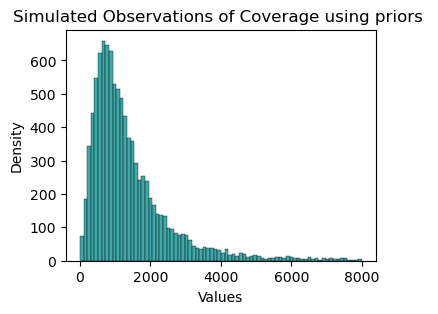

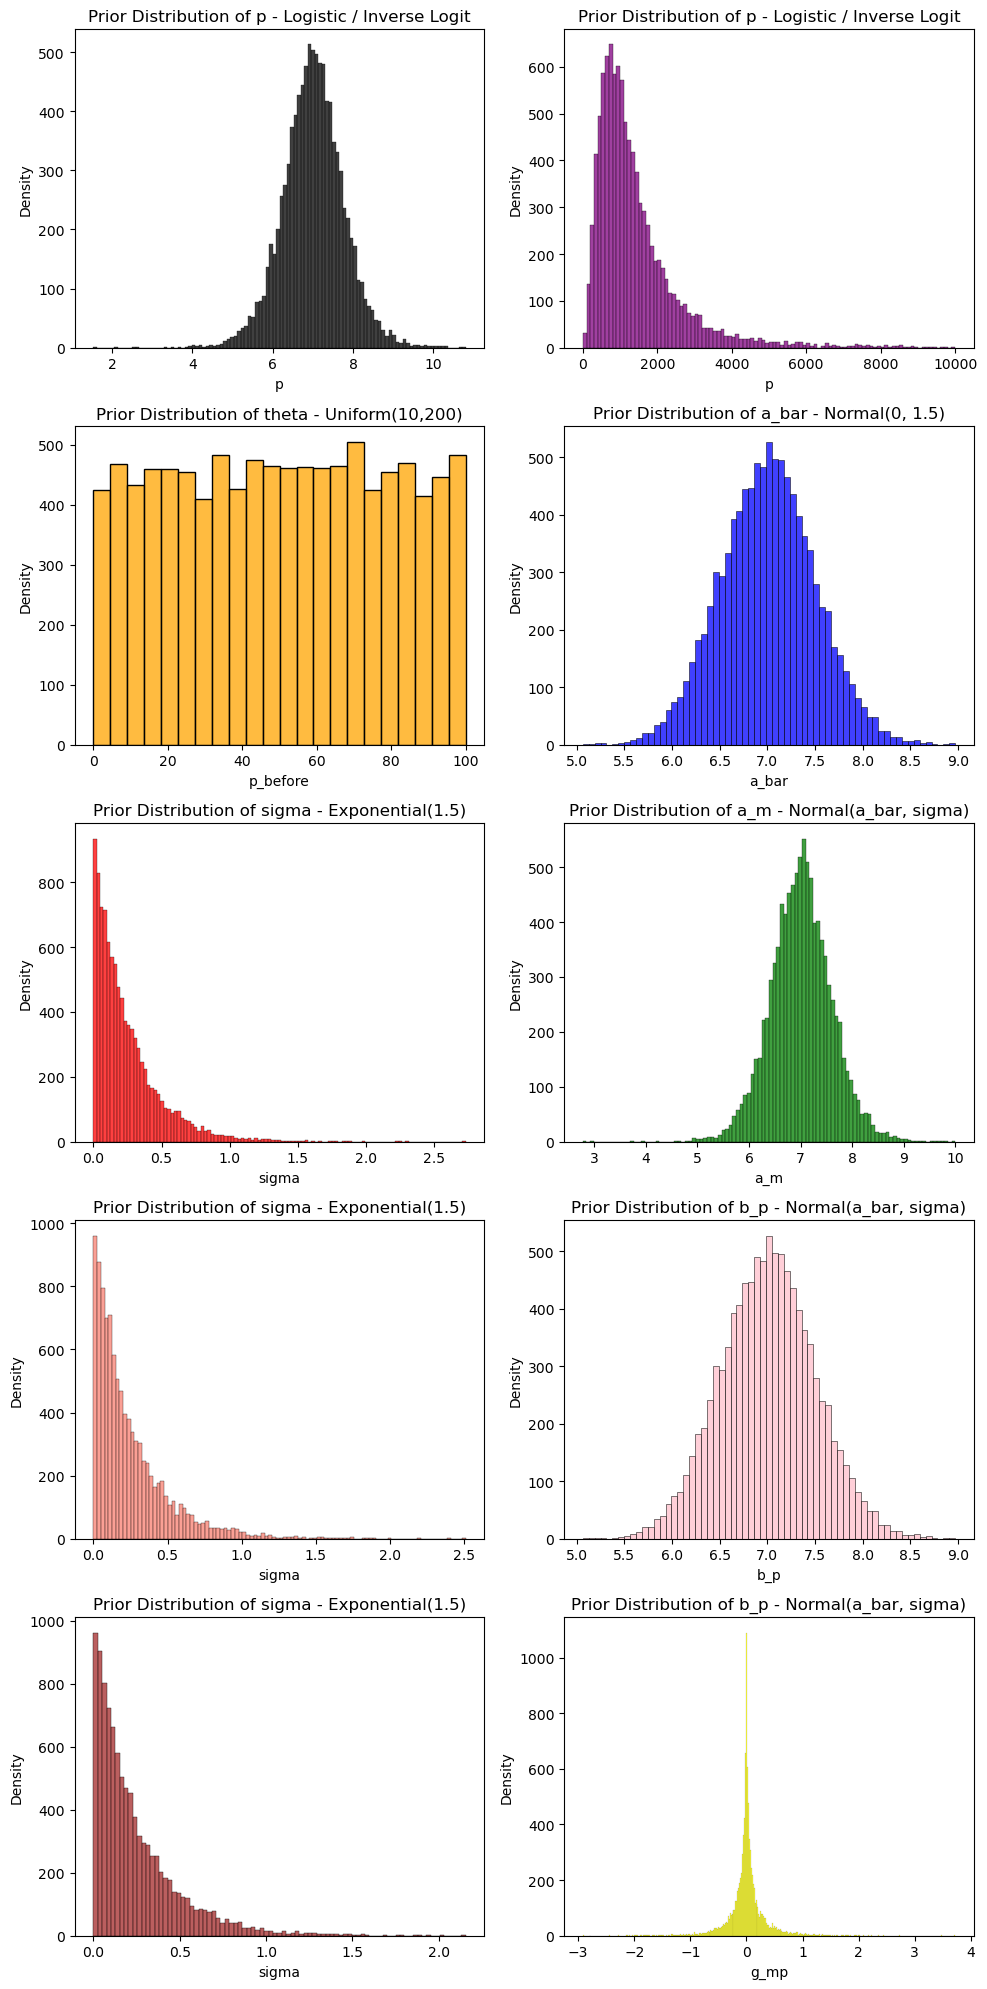

In [4]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def calc_prior_dist(s_a, s_b, s_g, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept and standard deviation for Modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Modules, Parameters and Interactions
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Non-centered parameterizations
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)


        # Link function (logit), unbounded to (0,1) probability
        pm.Deterministic('mu_before', a_m + b_p + g_mp)
        pm.Deterministic('mu', pm.math.exp(a_m + b_p + g_mp))
        
        # Beta distribution likelihood 
        pm.Uniform('theta', 0.0, 100)
        
        # Sample from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()

    simulated_observations = np.random.negative_binomial(n=prior_theta, p=(prior_theta)/(prior_mu + prior_theta))
    
    #Predicated observations
    plt.figure(figsize=(4, 3))

    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Coverage using priors ', 'Values',
                                     'darkcyan', bin_range=(0,8000))
    observation_plot.plot()


    plots = [
        HistogramPlot(idata.prior['mu_before'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'black'),
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'purple', bin_range=(0, 10000)),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior Distribution of theta - Uniform(10,200)', 'p_before', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior Distribution of a_bar - Normal(0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior Distribution of a_m - Normal(a_bar, sigma)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'salmon'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'b_p', 'pink'),
        HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'brown'),
        HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'g_mp', 'yellow')
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20))


s_a = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
s_b = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
s_g = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
a_bar_mu = FloatSlider(value=7, min=0, max=10, step=0.1, description='alpha bar mu (a_bar_mu):')
a_bar_sigma = FloatSlider(value=0.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')



#interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma)
calc_prior_dist(4,4,4,7,0.5)

In [4]:
import arviz as az

az.to_netcdf(trace, "model_overhead_trace.nc")

'model_overhead_trace.nc'

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>]],
      dtype=object)

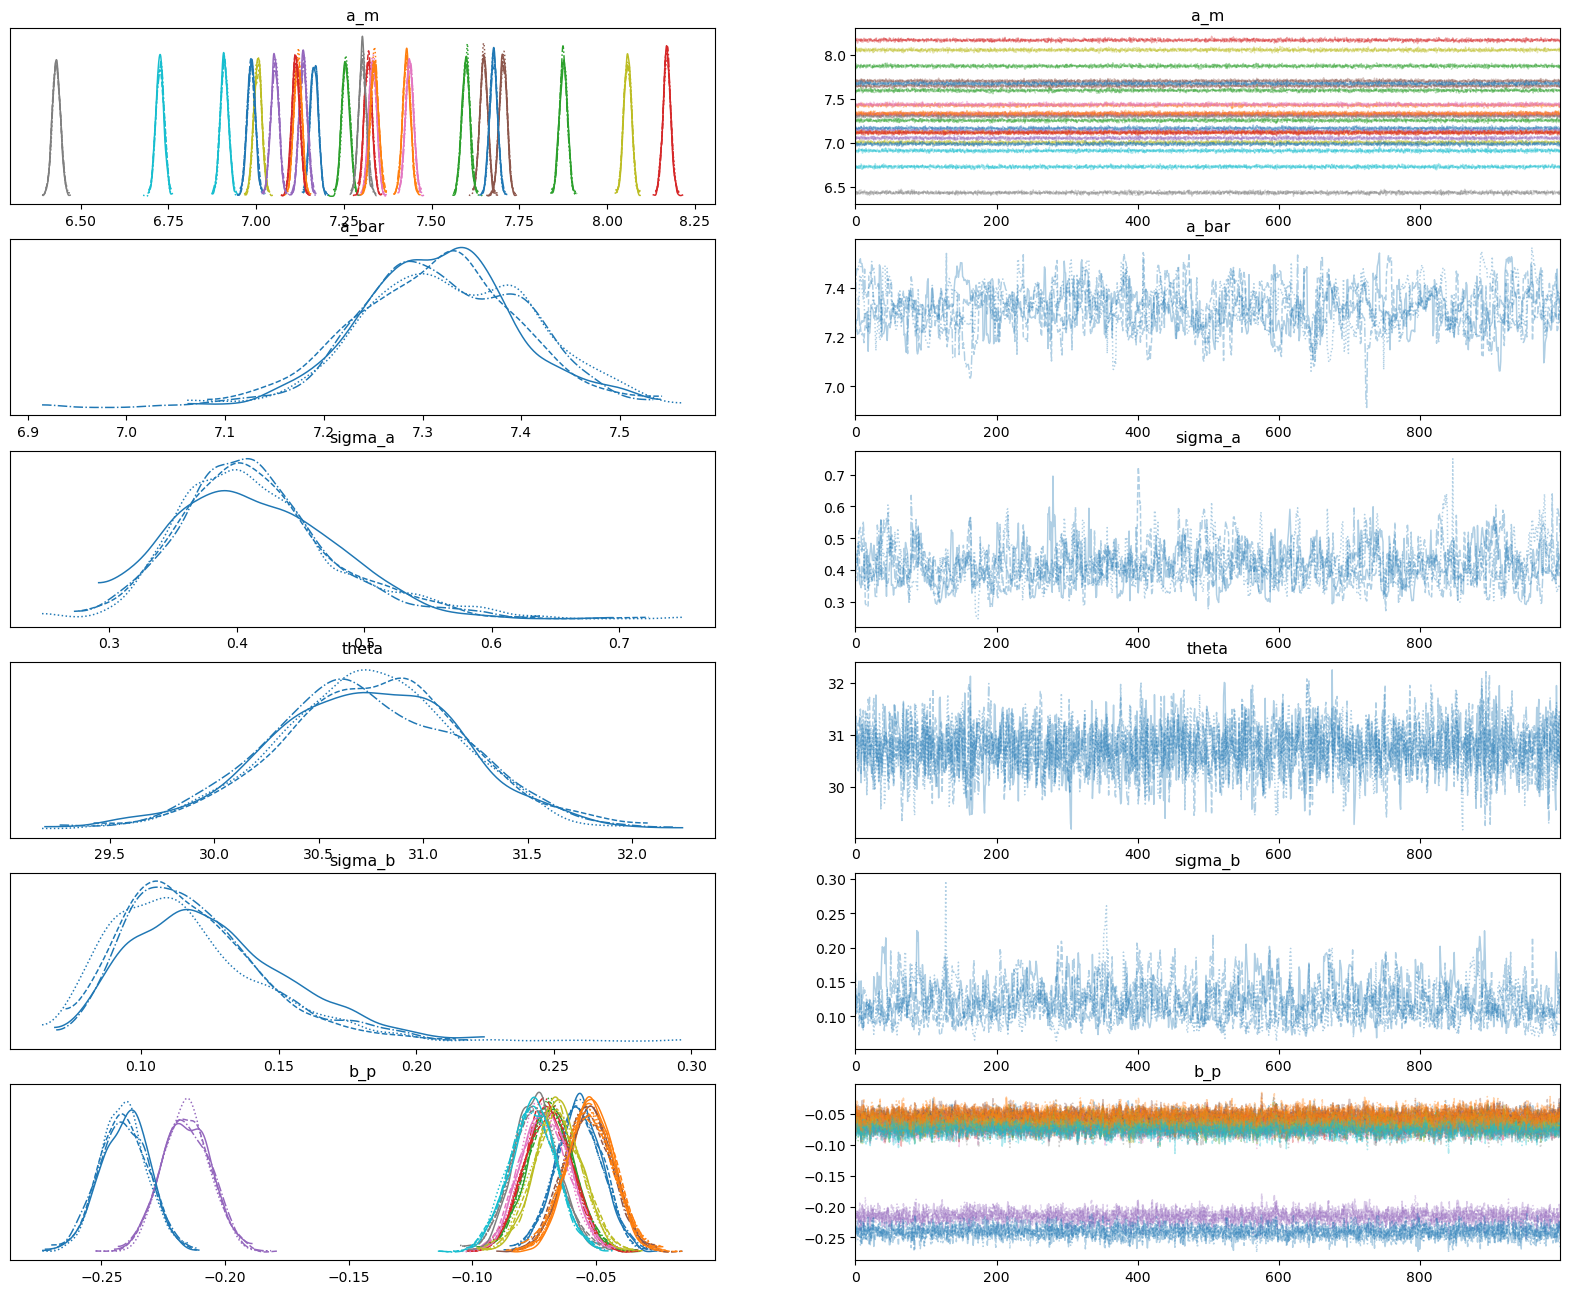

In [5]:
import arviz as az
from Notebooks.utils.inference_data_helper import create_inference_data_from_trace


# Example usage
trace = az.from_netcdf("model_overhead_trace.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p']
transformations = {
    #'a_m': log_to_exp,
    #'a_bar': log_to_exp,
    #'sigma_a': log_to_exp
}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
table = az.summary(idata, ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p'], hdi_prob=0.89)
az.plot_trace(idata, var_names=['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p'], figsize=(20, 16))